# Prediction of Drug Binding Affinity of Protein Using Spark ML

In my project I want to predict the likelihood of binding between sample drug compounds and target protein. Prediction of this binding affinity has application in protein engineering and computer aided drug discovery. If the activity value is less, then that is considered a good compound for potential drug for the protein activity control. 

For the project I have chosen ‘MAP kinase ERK2’ as my target protein. It is one type of Kinase protein which are intracellular enzymes that regulate cell growth and proliferation as well as the triggering and regulation of immune responses. Protein kinases are important therapeutic targets in cancer because of their critical role in signaling mechanisms that drive malignant cell characteristics. For this target protein we have binding affinity values for 4643 potential drug molecules.

## Dataset
- [Chembl Database](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4040/)
- Shape (3777, 5)
- Data Dictionary 
    - NumHDonors : No more than 5 hydrogen bond donors (the total number of nitrogen–hydrogen and oxygen–hydrogen bonds)
    - NumHAcceptors: No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
    - MW: A molecular mass less than 500 daltons.
    - LogP : An octanol-water partition coefficient[10] (log P) that does not exceed 5
    - bioactivity_class: Is the drug compund is active or inactive for target protein. 


## 1. Getting Data 

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

In [3]:
df.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL397591,Nc1ncc(/C=C/CNC(=O)c2cc(Br)c(Br)[nH]2)[nH]1,inactive,2500.0
1,CHEMBL35482,COc1cccc(-c2cc(=O)c3ccccc3o2)c1N,inactive,2800.0
2,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,active,2.5
3,CHEMBL356164,NC(=O)c1cc(Br)c(Br)[nH]1,inactive,2500.0
4,CHEMBL361708,NC1=NC(=O)/C(=C2\CCNC(=O)c3[nH]c(Br)cc32)N1,active,9.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777 entries, 0 to 3776
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  3777 non-null   object 
 1   canonical_smiles    3775 non-null   object 
 2   bioactivity_class   3777 non-null   object 
 3   standard_value      3777 non-null   float64
dtypes: float64(1), object(3)
memory usage: 118.2+ KB


In [5]:
df[df['canonical_smiles'].isnull()]

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
275,CHEMBL1909054,NaN,active,216.0
277,CHEMBL1909064,NaN,active,320.8


> The canonical_smiles is a linear text format which can describe the connectivity and chirality of a molecule. Canonical SMILES gives a single 'canonical' form for any particular molecule. Considering this if we use this feature to predict the values it will be very sparse input to the model so I will drop this column.

In [6]:
df=df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3775 entries, 0 to 3776
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  3775 non-null   object 
 1   canonical_smiles    3775 non-null   object 
 2   bioactivity_class   3775 non-null   object 
 3   standard_value      3775 non-null   float64
dtypes: float64(1), object(3)
memory usage: 147.5+ KB


> Using websites GUI download I was only able to get the molecule_id, Canonical_smiles, Bioactivity_class and therir standard_value. To get the other features I have used lipinski() function which was refered from (https://codeocean.com/explore/capsules?query=tag:data-curation)

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [9]:
df_lipinski = lipinski(df['canonical_smiles'])

In [10]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,389.051,2.2882,4.0,3.0
1,267.284,3.0508,1.0,4.0
2,466.541,4.3540,2.0,6.0
3,267.908,1.6386,2.0,1.0
4,324.138,0.0663,4.0,4.0
...,...,...,...,...
3770,312.333,1.7279,4.0,5.0
3771,312.333,1.7279,4.0,5.0
3772,402.454,2.3537,0.0,5.0
3773,481.350,3.1162,0.0,5.0


In [11]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [12]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3777 entries, 0 to 277
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  3775 non-null   object 
 1   canonical_smiles    3775 non-null   object 
 2   bioactivity_class   3775 non-null   object 
 3   standard_value      3775 non-null   float64
 4   MW                  3775 non-null   float64
 5   LogP                3775 non-null   float64
 6   NumHDonors          3775 non-null   float64
 7   NumHAcceptors       3775 non-null   float64
dtypes: float64(5), object(3)
memory usage: 265.6+ KB


In [13]:
df_combined.to_csv('bioactivity_model_data_final.csv', index=False)

## 2. Exploratory Data Analysis

In [14]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()

sc = spark.sparkContext
from pyspark.sql.types import StructType,StructField,DoubleType,StringType, IntegerType, FloatType

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

In [15]:
data = spark.read.csv('bioactivity_model_data_final.csv')

In [16]:
data.head(2)

[Row(_c0='molecule_chembl_id', _c1='canonical_smiles', _c2='bioactivity_class', _c3='standard_value', _c4='MW', _c5='LogP', _c6='NumHDonors', _c7='NumHAcceptors'),
 Row(_c0='CHEMBL397591', _c1='Nc1ncc(/C=C/CNC(=O)c2cc(Br)c(Br)[nH]2)[nH]1', _c2='inactive', _c3='2500.0', _c4='389.051', _c5='2.2882', _c6='4.0', _c7='3.0')]

In [17]:
schema = StructType([
  StructField("molecule_chembl_id", StringType(), False),
  StructField("canonical_smiles", StringType(), False),
  StructField("bioactivity_class", StringType(), False),
  StructField("MW", DoubleType(), False),
  StructField("LogP", DoubleType(), False),
  StructField("NumHDonors", DoubleType(), False),
  StructField("NumHAcceptors", DoubleType(), False),
])

In [18]:
data = spark.read.format("csv").schema(schema).load("bioactivity_model_data_final.csv")
cols = data.columns

In [19]:
data.show(5)

+------------------+--------------------+-----------------+------+------------------+------------------+-------------+
|molecule_chembl_id|    canonical_smiles|bioactivity_class|    MW|              LogP|        NumHDonors|NumHAcceptors|
+------------------+--------------------+-----------------+------+------------------+------------------+-------------+
|molecule_chembl_id|    canonical_smiles|bioactivity_class|  null|              null|              null|         null|
|      CHEMBL397591|Nc1ncc(/C=C/CNC(=...|         inactive|2500.0|           389.051|            2.2882|          4.0|
|       CHEMBL35482|COc1cccc(-c2cc(=O...|         inactive|2800.0|           267.284|3.0508000000000006|          1.0|
|      CHEMBL388978|CN[C@@H]1C[C@H]2O...|           active|   2.5| 466.5410000000003| 4.354000000000003|          2.0|
|      CHEMBL356164|NC(=O)c1cc(Br)c(B...|         inactive|2500.0|267.90799999999996|1.6385999999999998|          2.0|
+------------------+--------------------+-------

In [20]:
data.printSchema()

root
 |-- molecule_chembl_id: string (nullable = true)
 |-- canonical_smiles: string (nullable = true)
 |-- bioactivity_class: string (nullable = true)
 |-- MW: double (nullable = true)
 |-- LogP: double (nullable = true)
 |-- NumHDonors: double (nullable = true)
 |-- NumHAcceptors: double (nullable = true)



In [21]:
from pyspark.sql.functions import isnan, when, count, col
null_val=data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])

null_val.show()

+------------------+----------------+-----------------+---+----+----------+-------------+
|molecule_chembl_id|canonical_smiles|bioactivity_class| MW|LogP|NumHDonors|NumHAcceptors|
+------------------+----------------+-----------------+---+----+----------+-------------+
|                 2|               2|                2|  3|   3|         3|            3|
+------------------+----------------+-----------------+---+----+----------+-------------+



In [22]:
import pyspark.sql.functions as f
from functools import reduce

data.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in data.columns))).show()

+------------------+--------------------+-----------------+------+------------------+-----------------+-------------+
|molecule_chembl_id|    canonical_smiles|bioactivity_class|    MW|              LogP|       NumHDonors|NumHAcceptors|
+------------------+--------------------+-----------------+------+------------------+-----------------+-------------+
|molecule_chembl_id|    canonical_smiles|bioactivity_class|  null|              null|             null|         null|
|     CHEMBL4549667|CN1C(=O)[C@@H](N2...|         inactive|1000.0|              null|             null|         null|
|     CHEMBL4097778|CN1C(=O)[C@@H](N2...|         inactive|1000.0|              null|             null|         null|
|              null|                null|             null|  null|300.44200000000006|5.602600000000005|          1.0|
|              null|                null|             null|  null|310.39300000000003|4.396800000000003|          1.0|
+------------------+--------------------+---------------

> From the table we can see for 2 molecules there is missing data for all four features and for 2 molecules we don't have id or bioactivity_class data so I will drop these 4 rows.

In [23]:
data=data.dropna()
data.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in data.columns))).show()

+------------------+----------------+-----------------+---+----+----------+-------------+
|molecule_chembl_id|canonical_smiles|bioactivity_class| MW|LogP|NumHDonors|NumHAcceptors|
+------------------+----------------+-----------------+---+----+----------+-------------+
+------------------+----------------+-----------------+---+----+----------+-------------+



In [24]:
data.replace(['inactive', 'active'], ['0', '1'], 'bioactivity_class').show()

+------------------+--------------------+-----------------+--------+------------------+-------------------+-------------+
|molecule_chembl_id|    canonical_smiles|bioactivity_class|      MW|              LogP|         NumHDonors|NumHAcceptors|
+------------------+--------------------+-----------------+--------+------------------+-------------------+-------------+
|      CHEMBL397591|Nc1ncc(/C=C/CNC(=...|                0|  2500.0|           389.051|             2.2882|          4.0|
|       CHEMBL35482|COc1cccc(-c2cc(=O...|                0|  2800.0|           267.284| 3.0508000000000006|          1.0|
|      CHEMBL388978|CN[C@@H]1C[C@H]2O...|                1|     2.5| 466.5410000000003|  4.354000000000003|          2.0|
|      CHEMBL356164|NC(=O)c1cc(Br)c(B...|                0|  2500.0|267.90799999999996| 1.6385999999999998|          2.0|
|      CHEMBL361708|NC1=NC(=O)/C(=C2\...|                1|     9.0|           324.138|0.06629999999999997|          4.0|
|      CHEMBL255465|NC1=

In [25]:
df=data.toPandas()

In [26]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

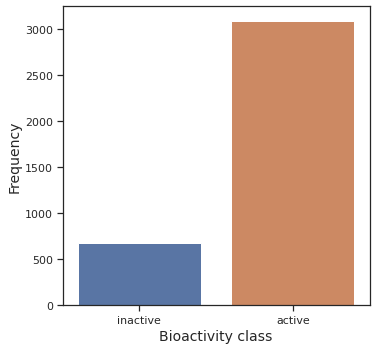

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df)
plt.xlabel('Bioactivity class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

> Graph shows that target values of the dataset is very imbalance. There are large amount of active class present.

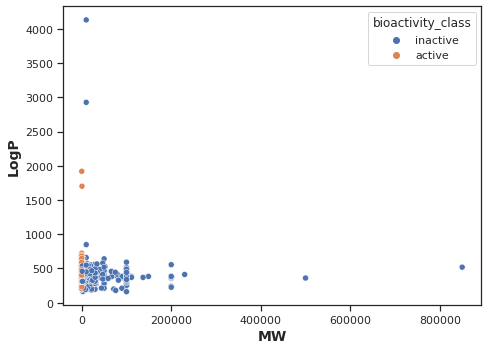

In [28]:
plt.figure(figsize=(7.5, 5.5))
sns.scatterplot(x='MW', y='LogP', data=df, hue='bioactivity_class' )
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.show()

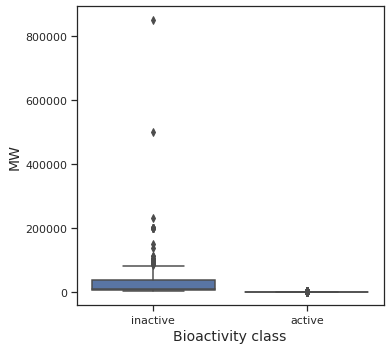

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df)
plt.xlabel('Bioactivity class', fontsize=14)
plt.ylabel('MW', fontsize=14)
plt.show()

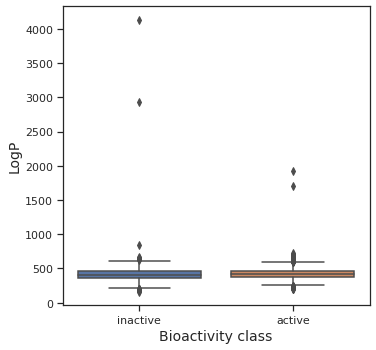

In [30]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df)
plt.xlabel('Bioactivity class', fontsize=14)
plt.ylabel('LogP', fontsize=14)
plt.show()

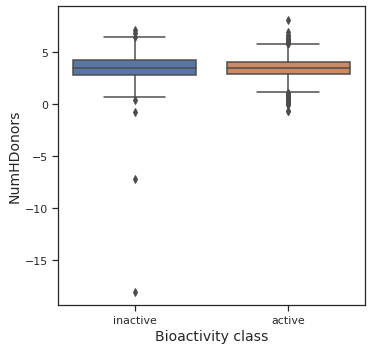

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df)
plt.xlabel('Bioactivity class', fontsize=14)
plt.ylabel('NumHDonors', fontsize=14)
plt.show()

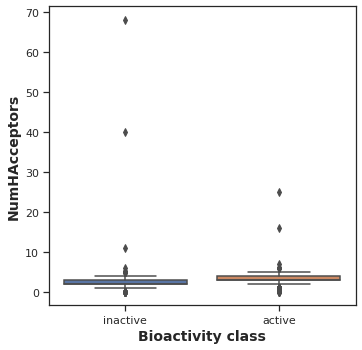

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data =df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

> For all the features there is no extreme difference for active and inactive class values. Correlation between molecular weight and LogP value for both classes is pretty similar. 

## 3. Modeling

In [33]:

# Creating pipelines for feature and label columns

import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

stages = [] 
label_stringIdx = StringIndexer(inputCol="bioactivity_class", outputCol="label")
stages += [label_stringIdx]

numericCols = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
stages += [assembler]

partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(data)
preppedDataDF = pipelineModel.transform(data)

In [34]:
# Splitting the data into test and training data

selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)

(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed=100)
print(trainingData.count())
print(testData.count())

3045
728


### Logistic Regression model

In [35]:
from pyspark.ml.classification import LogisticRegression
 

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
 
lrModel = lr.fit(trainingData)
lr_predictions = lrModel.transform(testData)
lr_selected = lr_predictions.select("label", "prediction", "probability")



In [38]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
evaluator = BinaryClassificationEvaluator()
lr_roc= evaluator.evaluate(lr_predictions)
('Logistic regression areaUnderROC:',evaluator.evaluate(lr_predictions))

('Logistic regression areaUnderROC:', 0.9984311554078998)

In [69]:
lr_y_true = lr_predictions.select(['label']).collect()
lr_y_pred = lr_predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
lr_accu=accuracy_score(lr_y_true, lr_y_pred)
lr_cf_matrix=confusion_matrix(lr_y_true, lr_y_pred)
print(classification_report(lr_y_true, lr_y_pred))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       602
         1.0       1.00      0.78      0.88       126

    accuracy                           0.96       728
   macro avg       0.98      0.89      0.93       728
weighted avg       0.96      0.96      0.96       728



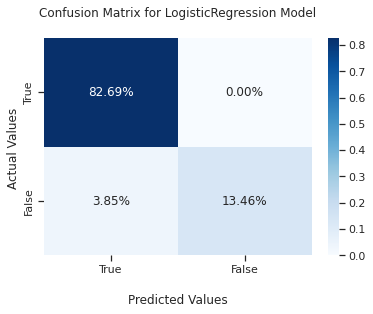

In [56]:
import seaborn as sns

ax = sns.heatmap(lr_cf_matrix/np.sum(lr_cf_matrix), annot=True,fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for LogisticRegression Model\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

plt.show()

### Decision Tree Classifier model

In [57]:

from pyspark.ml.classification import DecisionTreeClassifier
 
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
dt_cvModel = dt_cv.fit(trainingData)

print("numNodes = ", dt_cvModel.bestModel.numNodes)
print("depth = ", dt_cvModel.bestModel.depth)

dt_predictions = dt_cvModel.transform(testData)

numNodes =  25
depth =  6


In [58]:

dt_roc=evaluator.evaluate(dt_predictions)
dt_roc

0.9981015662078785

In [71]:
dt_selected = dt_predictions.select("label", "prediction", "probability")

dt_y_true = dt_predictions.select(['label']).collect()
dt_y_pred = dt_predictions.select(['prediction']).collect()
dt_accu=accuracy_score(dt_y_true, dt_y_pred)
cf_matrix=confusion_matrix(dt_y_true, dt_y_pred)
print(classification_report(dt_y_true, dt_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       602
         1.0       0.95      0.90      0.93       126

    accuracy                           0.98       728
   macro avg       0.97      0.95      0.96       728
weighted avg       0.98      0.98      0.98       728



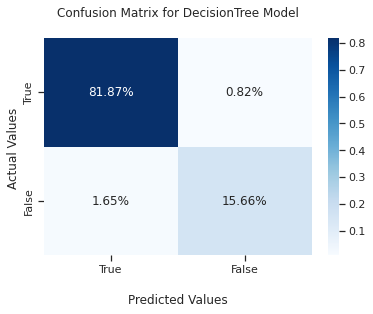

In [60]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for DecisionTree Model\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

plt.show()

### Random Forest Classifier model

In [61]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [10,15,20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(trainingData)
rf_predictions = cvModel.transform(testData)


rf_roc=evaluator.evaluate(rf_predictions)
rf_roc

1.0

In [72]:
rf_selected = rf_predictions.select("label", "prediction", "probability")

rf_y_true = rf_predictions.select(['label']).collect()
rf_y_pred = rf_predictions.select(['prediction']).collect()
rf_accu=accuracy_score(rf_y_true, rf_y_pred)
cf_matrix=confusion_matrix(rf_y_true, rf_y_pred)
print(classification_report(rf_y_true, rf_y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       602
         1.0       1.00      1.00      1.00       126

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728



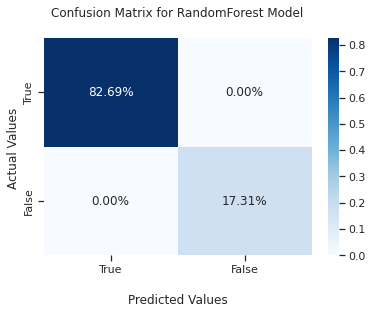

In [63]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for RandomForest Model\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

plt.show()

## 4. Results

In [73]:

model_Compare = pd.DataFrame({'Models':['Logistic Regression','Decision Tree', 'Random Forest'], 
                         'Performance_(areaUnderROC)':[lr_roc,dt_roc,rf_roc],
                             'Accuracy':[lr_accu,dt_accu,rf_accu]})
model_Compare

,Models,Performance_(areaUnderROC),Accuracy
0,Logistic Regression,0.998431,0.961538
1,Decision Tree,0.998102,0.975275
2,Random Forest,1.000000,1.000000


> When the positive class is larger in the dataset then ROC metrics are most suitable. Because the precision and recall would reflect mostly the ability of prediction of the positive class and not the negative class which will naturally be harder to detect due to the smaller number of samples. So if we compare the areUnderROC for all the three models there is not much difference. Random Forest is giving 1 value but it is probably overfitting to the dataset. Currently my data is very small, that's why decision trees and random forests are fast. If we try it on large scale DT and RF will be very computationally costly so Logistic Regression will be the best choice. We can see Logistic Regression is giving better performance 0.9984. Also the accuracy of the Logistic Regression model is 96% which is a pretty good score. 

#### References 
- https://towardsdatascience.com/apache-spark-mllib-tutorial-part-3-complete-classification-workflow-a1eb430ad069
- https://docs.databricks.com/_static/notebooks/binary-classification.html
- https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
- https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five
